In [1]:
# Import libraries
%matplotlib inline
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import re
import sklearn
from sklearn import preprocessing
from sklearn import mixture
import scipy

# Step 0: Data import and preprocessing

In [2]:
# Import OTU data
df = pd.read_csv(open('YT_bioreactor_data.csv','rb'),skip_blank_lines=True)
df = df.rename(columns={'Unnamed: 0': 'SampleID'})

In [3]:
##### Add 1 to all OTU populations:
df_plus = df.copy()
df_plus.loc[:, 'Otu8':'Otu819'] = df.loc[:, 'Otu8':'Otu819'] + 1

# Take log10 of all population numbers:
df_log10 = df_plus.copy()
df_log10.loc[:, 'Otu8':'Otu819'] = np.log10(df_plus.loc[:, 'Otu8':'Otu819'])

df_log10_values = df_log10.loc[:,'Otu8':'Otu819'].values
log_abundances = df_log10_values.T

# Step 1: Gaussian Mixtures
Note 1: Due to EM starting with different initializations each time, the IC-optimal number of clusters may be different. So run the algorithm many times, and take a majority vote. 

Note 2: Due to the label switching phenomenon, the cluster labels from each run will be completely different.

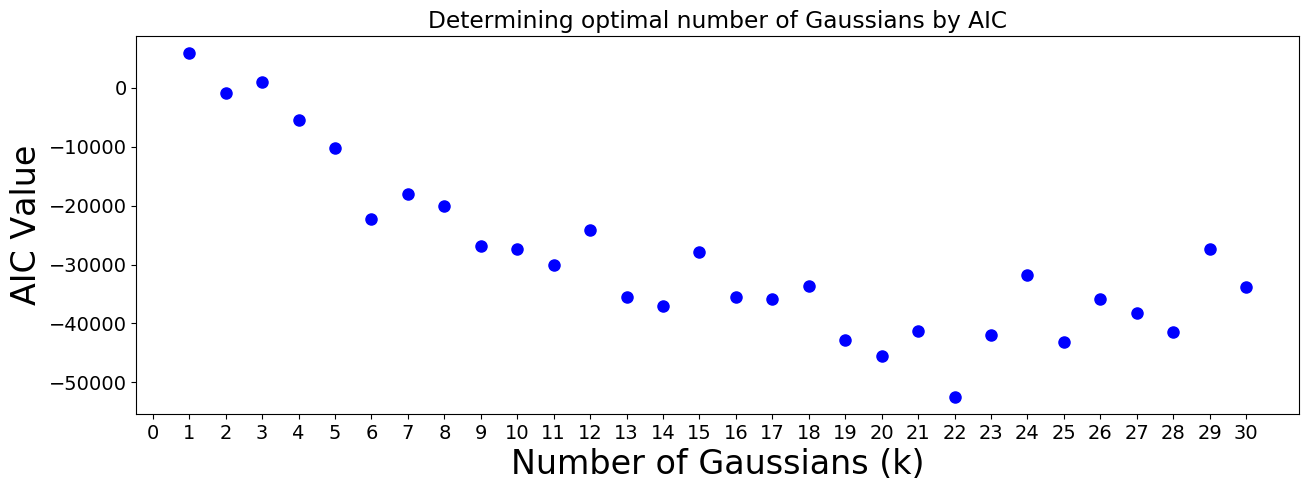

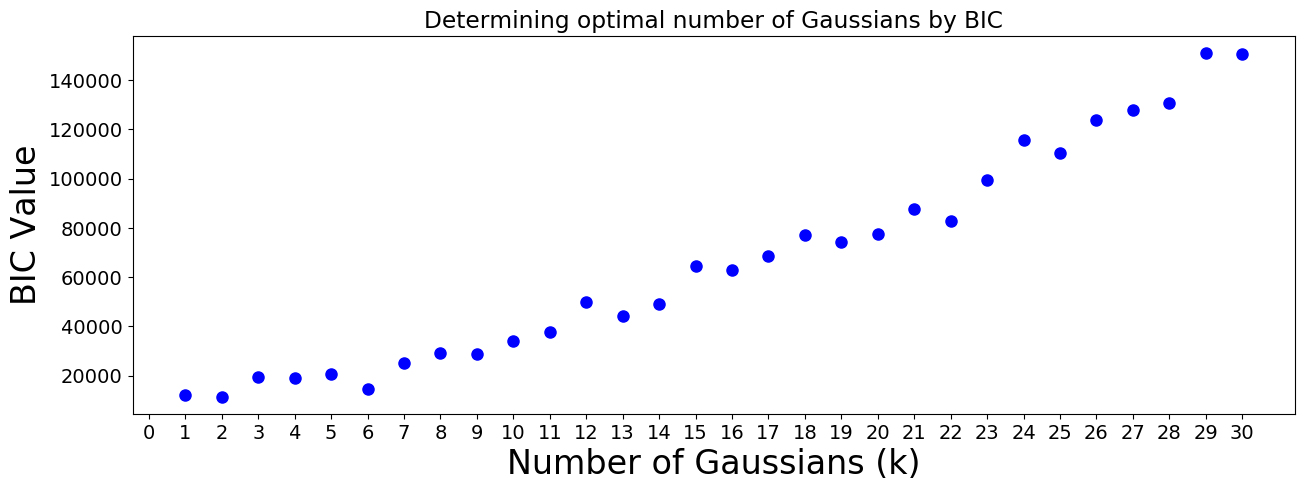

In [4]:
# Create Gaussians models with different number of total Gaussians, then evaluate model fit using ICs:
n_k = 30
#first_few = []
GMM_AIC = []
GMM_BIC = []
for j in range (1,n_k+1):
    GMM = mixture.GaussianMixture(n_components=j, covariance_type='full').fit(log_abundances)
    value_AIC = GMM.aic(log_abundances) # Calculate Akaike Information Criterion
    value_BIC = GMM.bic(log_abundances) # Calculate Bayesian Information Criterion
    #GMM_hat = GMM.predict(log_abundances)
    #first_few.append(GMM_hat[0:20])
    GMM_AIC.append(value_AIC)
    GMM_BIC.append(value_BIC)
GMM_AIC = np.concatenate((np.linspace(1,n_k,num=n_k).reshape(-1,1),np.array(GMM_AIC).reshape(-1,1)),axis=1)
GMM_BIC = np.concatenate((np.linspace(1,n_k,num=n_k).reshape(-1,1),np.array(GMM_BIC).reshape(-1,1)),axis=1)

# Plot AIC values:
fig = plt.figure(figsize=(15,5), dpi=100)
plt.rc("font", size=14)
plt.plot(GMM_AIC[:,0],GMM_AIC[:,1],'.',markersize=16,color='blue')
#plt.ylim(-0.1,0.1)
plt.xlabel("Number of Gaussians (k)", fontsize=24)
plt.ylabel("AIC Value", fontsize=24)
plt.title("Determining optimal number of Gaussians by AIC")
plt.xticks(np.arange(0,n_k+1,1))
#plt.yticks(fontsize=20)
plt.show()

# Plot BIC values:
fig = plt.figure(figsize=(15,5), dpi=100)
plt.rc("font", size=14)
plt.plot(GMM_BIC[:,0],GMM_BIC[:,1],'.',markersize=16,color='blue')
#plt.ylim(-0.1,0.1)
plt.xlabel("Number of Gaussians (k)", fontsize=24)
plt.ylabel("BIC Value", fontsize=24)
plt.title("Determining optimal number of Gaussians by BIC")
plt.xticks(np.arange(0,n_k+1,1))
#plt.yticks(fontsize=20)
plt.show()

In [5]:
# Calculate number of components based on minimum IC values:
k_AIC = np.argmin(GMM_AIC,axis=0)[1]+1
k_BIC = np.argmin(GMM_BIC,axis=0)[1]+1

In [6]:
k_AIC

22

In [7]:
# Redo clustering based on the num of components with min AIC:
GM_AIC = mixture.GaussianMixture(n_components=k_AIC, covariance_type='full').fit(log_abundances)
GM_AIC_hat = GM_AIC.predict(log_abundances)
GM_AIC_hat

array([20, 17,  9, 17, 17, 17, 19,  9,  9,  4,  3, 20,  4, 10, 20,  9,  9,
        2, 11, 14, 11, 14, 20,  9,  4, 14,  2, 11, 14,  2,  6, 20, 19, 21,
       11,  1, 14,  6, 11, 21,  1, 11, 13,  6, 21,  8,  2, 19, 21, 14, 21,
       19, 16, 15,  1,  2,  2, 16,  6, 21, 21, 21,  0, 19, 20, 21, 11, 21,
       15,  2,  2,  2,  6, 11,  2,  2, 16, 21, 14, 13, 11,  2, 11,  1, 11,
       21,  5, 11, 11,  8, 12, 18,  2, 21, 16,  5, 21, 14,  2,  6,  1,  2,
       12, 19, 13,  1, 16,  1,  6, 16, 21,  5, 13,  6,  2,  1,  8,  8,  1,
       11, 21,  2, 21,  6,  6,  2,  1,  2,  1, 13, 21,  1,  5,  6, 21, 16,
       16,  1, 18,  2, 16, 15, 16, 13, 21, 16, 16,  6,  5, 11,  1,  6, 16,
        1, 11,  6, 16, 21, 18,  1, 21,  5, 13, 16,  6, 16, 16,  6,  6,  1,
        8,  1,  6, 16,  1,  1,  6, 12, 13, 21, 19, 16,  1,  6, 16,  6,  1,
        1,  6, 16, 12, 18,  1,  1, 13,  6,  5,  6,  1,  1, 13,  1, 16,  1,
        5,  1,  1,  1,  6,  7,  1, 16, 12,  1, 16,  1, 16,  1,  7, 19,  6,
       15, 16, 19,  1,  0

**Sanity check:** Due to EM being non-convex and label switching, do we see the individual OTUs falling into the same groups on every run? Let's do an experiment over $n_{runs}$ runs.

In [8]:
n_runs = 10
n_OTUs = df_log10_values.shape[1]
GM_AIC_hat = np.zeros((n_OTUs,n_runs))

for i in range(0,n_runs):
    GM_AIC = mixture.GaussianMixture(n_components=k_AIC, covariance_type='full').fit(log_abundances)
    GM_AIC_hat[:,i] = GM_AIC.predict(log_abundances)                                     
                                     
# Remake as dataframe with OTU labels
OTU_columns = df_plus.loc[:, 'Otu8':'Otu819'].columns
OTU_labels_experiment = pd.DataFrame(data = GM_AIC_hat.T,columns = OTU_columns)  
OTU_labels_experiment

,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,Otu141,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
0,16.0,6.0,1.0,6.0,6.0,6.0,8.0,1.0,9.0,1.0,...,0.0,11.0,0.0,0.0,2.0,7.0,7.0,7.0,0.0,0.0
1,20.0,6.0,0.0,6.0,12.0,6.0,5.0,0.0,18.0,0.0,...,11.0,9.0,11.0,11.0,17.0,19.0,19.0,19.0,11.0,11.0
2,9.0,11.0,18.0,11.0,11.0,11.0,9.0,18.0,18.0,5.0,...,19.0,4.0,19.0,19.0,6.0,0.0,0.0,0.0,19.0,19.0
3,16.0,4.0,6.0,4.0,17.0,4.0,14.0,6.0,17.0,7.0,...,13.0,12.0,13.0,13.0,21.0,11.0,19.0,19.0,13.0,13.0
4,12.0,4.0,5.0,4.0,19.0,4.0,12.0,5.0,5.0,20.0,...,17.0,11.0,17.0,17.0,2.0,9.0,0.0,0.0,17.0,17.0
5,19.0,6.0,18.0,6.0,8.0,6.0,12.0,18.0,8.0,2.0,...,20.0,3.0,20.0,20.0,4.0,7.0,7.0,0.0,20.0,20.0
6,20.0,4.0,19.0,4.0,1.0,4.0,3.0,19.0,1.0,9.0,...,14.0,18.0,14.0,14.0,15.0,8.0,14.0,14.0,14.0,14.0
7,17.0,5.0,21.0,5.0,7.0,5.0,12.0,21.0,7.0,2.0,...,9.0,9.0,9.0,9.0,4.0,6.0,11.0,11.0,11.0,11.0
8,16.0,15.0,10.0,15.0,15.0,15.0,8.0,10.0,13.0,10.0,...,19.0,6.0,19.0,19.0,9.0,14.0,14.0,14.0,19.0,19.0
9,12.0,3.0,1.0,3.0,3.0,3.0,11.0,1.0,9.0,1.0,...,20.0,5.0,20.0,20.0,7.0,17.0,17.0,17.0,20.0,20.0


In [9]:
# Take a random row as the predicted labels:
rand_row = np.random.randint(0, n_runs)

GM_AIC_hat = OTU_labels_experiment.values[rand_row,:]
GM_AIC_hat

array([ 9., 11., 18., 11., 11., 11.,  9., 18., 18.,  5.,  3.,  9.,  5.,
        9.,  9., 18.,  8., 20.,  1.,  1.,  1., 17.,  9.,  5.,  5.,  1.,
       20.,  1., 17.,  9.,  7.,  9., 14., 10., 10., 19.,  8.,  7.,  1.,
       10., 19., 20., 21.,  7., 10., 14., 13.,  7., 10.,  1., 10., 14.,
        2., 16., 19., 20., 20.,  2., 20., 10.,  6., 10., 15.,  7.,  9.,
       10.,  1., 10., 16.,  7., 20., 20.,  7., 20.,  9., 20.,  2., 10.,
        8., 21., 20., 20., 20., 19.,  1., 10.,  2.,  1., 20., 13.,  4.,
       12., 20., 10.,  2.,  2., 10.,  8., 20.,  7., 19.,  7.,  4., 14.,
        0., 19.,  2., 19.,  6.,  2., 10., 10., 21.,  7., 13.,  6., 14.,
       13., 19., 20., 10.,  7., 10.,  6.,  6., 20., 19., 13., 19.,  0.,
       10.,  6.,  2.,  6., 10., 19.,  2., 19., 12., 20.,  2., 16., 19.,
        0., 10., 19.,  2.,  6.,  2., 20., 19.,  6.,  2., 19., 20.,  6.,
        2., 10., 12., 19., 10.,  2., 21., 19.,  7.,  2.,  2.,  6.,  6.,
       19., 14., 19.,  7.,  2., 19.,  6.,  6.,  4., 21., 10.,  7

In [10]:
# Re-create as dataframe, then export
GM_labels_df = pd.DataFrame(data = GM_AIC_hat.reshape(1,-1),columns = OTU_columns)  
GM_labels_df.to_pickle("Gaussian_labels.pkl")

### Determine members for each Gaussian cluster

In [11]:
# Assign samples to this Gaussian mixture clustering:
OTU_columns = df.loc[:, 'Otu8':'Otu819'].columns

# Match each OTU to its corresponding cluster
GM_df = pd.DataFrame(data = GM_AIC_hat.reshape(1,-1),columns = OTU_columns)

# Create a tally of all the OTUs for each cluster
cluster_labels = np.linspace(0,k_AIC-1,k_AIC).astype(int)
cluster_tally = pd.DataFrame(index=cluster_labels,columns=np.linspace(1,305,305).astype(int))

for i in cluster_labels:
    members = []
    for j in OTU_columns:
        if GM_df.loc[:,j].values == i:
            members.append(j)
    cluster_tally.values[i,0:len(members)] = members
cluster_tally = cluster_tally.dropna(axis='columns',how='all')

# Output as csv file
cluster_tally.to_csv('cluster_tally_Gaussian.csv')

In [12]:
# Grab the Gaussian mixture means
Mean_coords = GM_AIC.means_.T
df_log_relevant = df_log10.loc[:,'Otu8':'Otu819']
num_samples = df_log_relevant.shape[0]
closest_OTUs = []

# First determine the centroid coordinates for all clusters
centroids = np.zeros((num_samples,k_AIC))
for i in range(0,k_AIC):
    members = cluster_tally.loc[[i]].dropna(axis=1).values[0].tolist()
    member_coords = df_log_relevant[members].values
    centroid_coords = Mean_coords[:,i]
    
    # Within each cluster, determine the OTU closest to mean (in terms of Euclidean distance) 
    dist_matrix = scipy.spatial.distance_matrix(centroid_coords.reshape(1,-1),member_coords.T)
    closest_index = np.argmin(dist_matrix)
    closest_OTU = members[closest_index]
    closest_OTUs.append(np.asarray(closest_OTU).tolist())

In [13]:
# Export the representative OTU labels
np.save("closest_OTUs_Gaussian.npy",np.asarray(closest_OTUs))

In [14]:
closest_OTUs

['Otu3313',
 'Otu31',
 'Otu49',
 'Otu6',
 'Otu5116',
 'Otu22',
 'Otu2913',
 'Otu195',
 'Otu4031',
 'Otu38',
 'Otu3705',
 'Otu1',
 'Otu65',
 'Otu1447',
 'Otu48',
 'Otu52',
 'Otu112',
 'Otu7347',
 'Otu23',
 'Otu4273',
 'Otu6945',
 'Otu1145']

### Plots

In [15]:
k_AIC

22

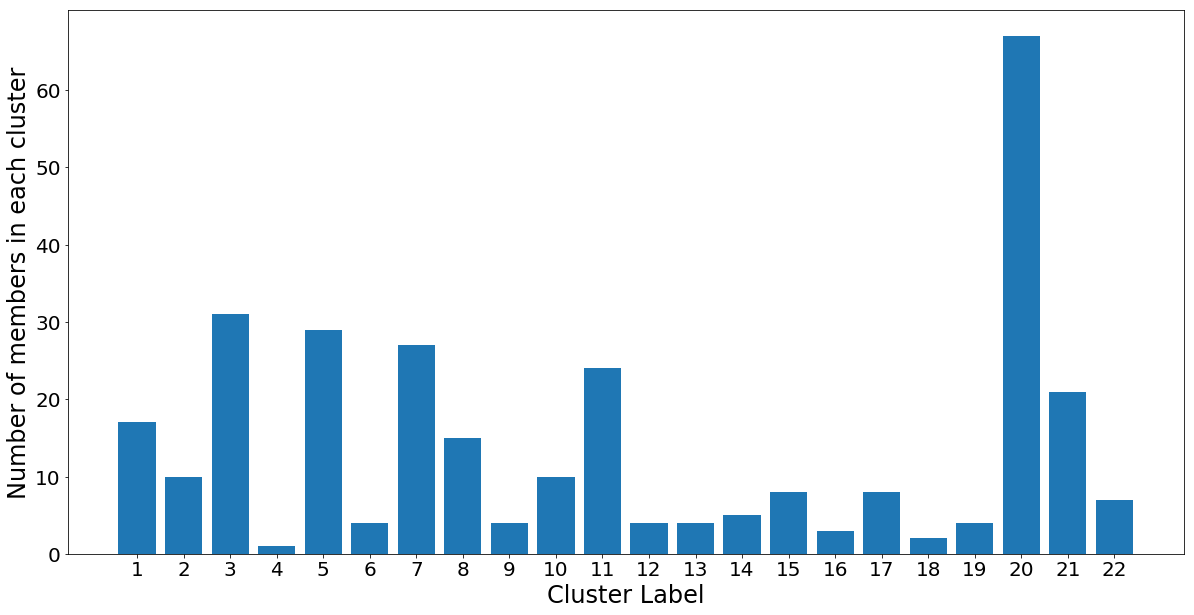

In [16]:
## Histogram 1: Show how many members are in each cluster
num_members_array = []
for i in cluster_tally.index:
    num_members = cluster_tally.loc[[i],:].columns.shape-cluster_tally.loc[[i],:].isnull().sum().sum()
    num_members_array.append(num_members)
num_members_array = np.asarray(num_members_array)

plt.figure(figsize=(20,10))
plt.bar(np.linspace(1,k_AIC,k_AIC).astype(int),num_members_array.reshape(-1))
plt.xticks(np.arange(1,k_AIC+1,1))
plt.xlabel("Cluster Label",fontsize=24)
plt.ylabel("Number of members in each cluster",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0,70,step=10),fontsize=20)
#plt.title("Cluster population histogram",fontsize=24)
plt.show()

In [17]:
print(num_members_array)
print(np.sum(num_members_array))

[[17]
 [10]
 [31]
 [ 1]
 [29]
 [ 4]
 [27]
 [15]
 [ 4]
 [10]
 [24]
 [ 4]
 [ 4]
 [ 5]
 [ 8]
 [ 3]
 [ 8]
 [ 2]
 [ 4]
 [67]
 [21]
 [ 7]]
305


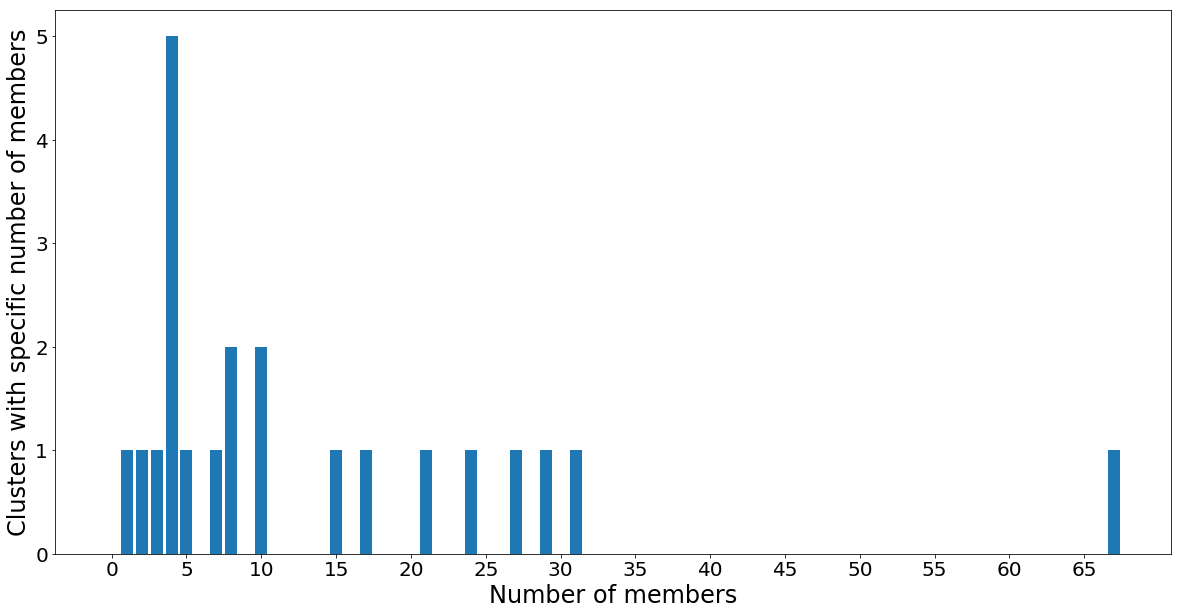

In [18]:
## Histogram 2: Show how many clusters have 1 member, 2 members, etc.
num_clusters_array = []
for i in range(0,np.max(num_members_array)+1):
    sum_term = 0
    for j in range(0,num_members_array.shape[0]):
        if num_members_array[j] == i:
            sum_term += 1
    num_clusters_array.append(sum_term)
num_clusters_array = np.asarray(num_clusters_array)

plt.figure(figsize=(20,10))
plt.bar(np.linspace(0,np.max(num_members_array),np.max(num_members_array)+1).astype(int),num_clusters_array.reshape(-1)) 
plt.xticks(np.arange(0,np.max(num_members_array)+1,step=5),fontsize=20)
plt.xlabel("Number of members",fontsize=24)
plt.ylabel("Clusters with specific number of members",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0,6,step=1),fontsize=20)
#plt.title("Cluster membership histogram")
plt.show()